# Homework 3
* Author: Kenji Oman ([github profile](https://github.com/kenjioman))
* Date: 5 August 2019

Original homework can be found [in the github reopo](https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week03.pdf).  Questions copied here in line with the work to make it easier to follow.

In [1]:
# Make necessary imports
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk')

from IPython.display import display, Markdown

## Preamble
All three problems below are based on the same data. The data in data(foxes)
are 116 foxes from 30 different urban groups in England. These foxes are like
street gangs. Group size varies from 2 to 8 individuals. Each group maintains its own (almost exclusive) urban territory. Some territories are larger
than others. The `area` variable encodes this information. Some territories
also have more `avgfood` than others. We want to model the `weight` of each
fox. For the problems below, assume this DAG:

![Fox DAG](./images/wk3_dag.PNG)

## Problem 1
Use a model to infer the total causal influence of `area` on `weight`. Would
increasing the area available to each fox make it heavier (healthier)? You
might want to standardize the variables. Regardless, use prior predictive
simulation to show that your model's prior predictions stay within the possible outcome range.

In [2]:
# First, load the data
fox = pd.read_csv('../../Data/foxes.csv', sep=';')
fox.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


group        False
avgfood      False
groupsize    False
area         False
weight       False
dtype: bool

,group,avgfood,groupsize,area,weight
count,116.000000,116.000000,116.000000,116.000000,116.000000
mean,17.206897,0.751724,4.344828,3.169138,4.529655
std,8.002736,0.198316,1.538511,0.928354,1.184023
min,1.000000,0.370000,2.000000,1.090000,1.920000
25%,11.750000,0.660000,3.000000,2.590000,3.720000
50%,18.000000,0.735000,4.000000,3.130000,4.420000
75%,24.000000,0.800000,5.000000,3.772500,5.375000
max,30.000000,1.210000,8.000000,5.070000,7.550000


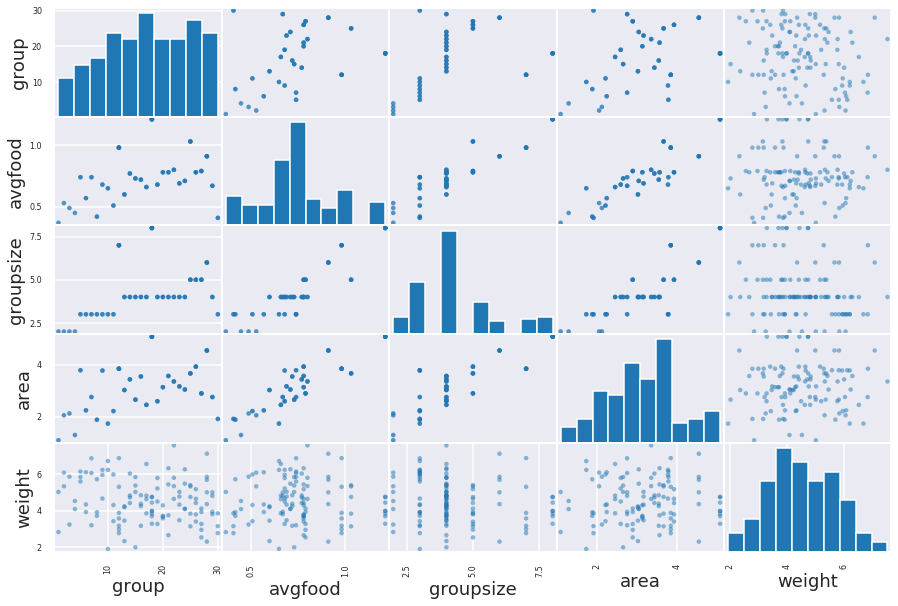

In [3]:
# Check for missing values/ summary statistics/ quick visual
display(fox.isna().any())
display(fox.describe())
pd.plotting.scatter_matrix(fox, figsize=(15,10))
plt.show()

We see above that we don't have any missing values, which is good, and looking at the histograms in the scatter matrix, we see that no value in any of the fields seem to jump out as an encoding for missing-ness, or anything out of the ordinary.  The summary statistics and plots also show that we don't seem to have any outliers or [inliers](https://stats.oecd.org/glossary/detail.asp?ID=3464) that we can see.  We also observe that the scales of the `avgfood` is, in particular, fairly different from the others (ignore `group` as that field is not pertinent for this assignment).

As the problem prompt suggested, let's first standardize these variables so that we can more easily think about how one variable relates to another in standard units.

In [4]:
# Standardize the variables we care about
fox_std = fox.copy()
temp = fox.loc[:, 'avgfood':'weight']
fox_std.loc[:, 'avgfood':'weight'] = (temp - temp.mean()) / temp.std()
fox_std.describe()

,group,avgfood,groupsize,area,weight
count,116.000000,1.160000e+02,1.160000e+02,1.160000e+02,1.160000e+02
mean,17.206897,-2.718132e-16,-1.531342e-16,-3.012916e-15,-3.091397e-16
std,8.002736,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,1.000000,-1.924829e+00,-1.524089e+00,-2.239596e+00,-2.204059e+00
25%,11.750000,-4.625154e-01,-8.741098e-01,-6.238331e-01,-6.838173e-01
50%,18.000000,-8.433082e-02,-2.241307e-01,-4.215842e-02,-9.261240e-02
75%,24.000000,2.434292e-01,4.258483e-01,6.499268e-01,7.139601e-01
max,30.000000,2.310838e+00,2.375785e+00,2.047562e+00,2.550918e+00


Examining the DAG:
```
area  ->  avgfood  ->  groupsize
             \              /
              \-> weight <-/
```
We observe that `avgfood` and `groupsize` both act as pipes between `area` and `weight`.  So, if we want to total causal inference of `area` on `weight`, we should just use a univariate model:
$$
weight = \alpha + \beta \cdot area
$$
and not condition on either `avgfood` or `groupsize` as that would close the pipe.  Since we have standardized the variables, let's first try out as our full model specification:
$$\begin{eqnarray}
\alpha &=& \mathrm{Normal}(0, 0.5) \\
\beta &=& \mathrm{Normal}(0, 1) \\
\mu &=& \alpha + \beta \cdot area \\
\sigma &=& \mathrm{Exponential}(1) \\
weight &=& \mathrm{Normal}(\mu, \sigma) \\
\end{eqnarray}$$
Now, do some prior predictive simulations to make sure our values seem reasonable.

### Prior Predictive Simulations

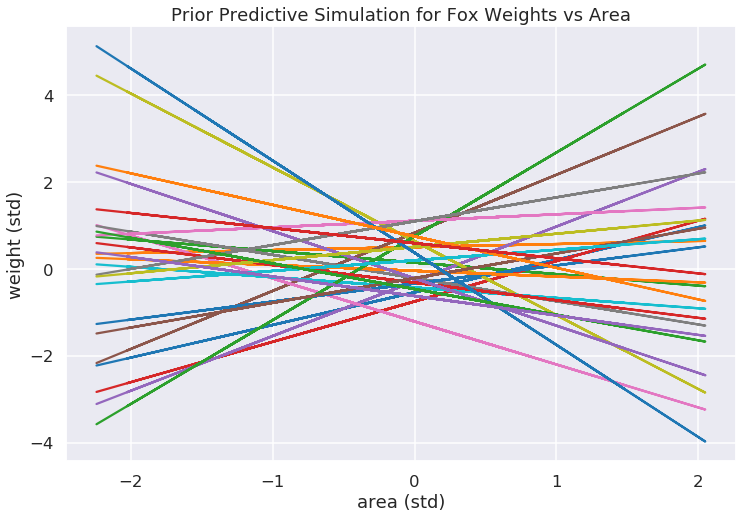

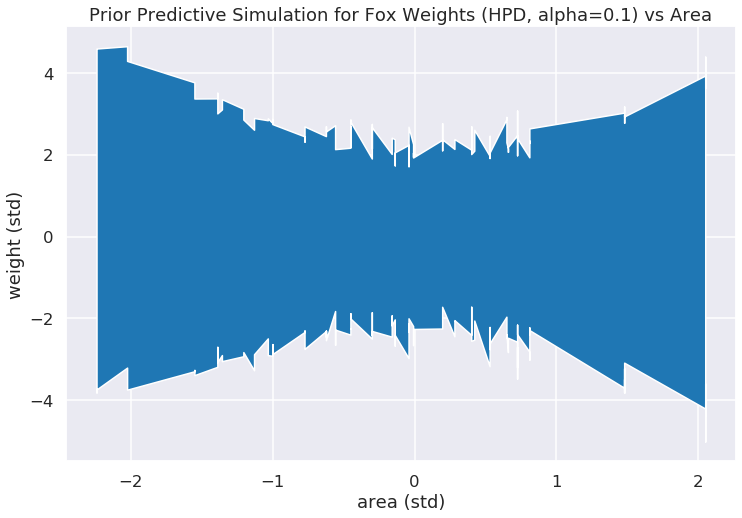

In [5]:
# Set the # of lines we wish to model
N = 25
# I found we can do the predictive simulation using pymc3 directly, so
# let's try that (that way, we know we have the same parameters in our
# model for both our prior and posterior predictive samples)
np.random.seed(123)
with pm.Model() as mdl_1:
    a = pm.Normal('a', mu=0, sd=0.5)
    # Name the slope with a little more meaning
    area_effect = pm.Normal('area_effect', mu=0, sd=1)
    mu = pm.Deterministic('mu', a + area_effect * fox_std.area.values)
    sigma = pm.Exponential('sigma', lam=1)
    weight = pm.Normal('weight', mu=mu, sd=sigma, observed=fox_std.weight)
    
    prior_1 = pm.sample_prior_predictive()


# Now, plot these lines
plt.figure(figsize=(12,8))
plt.plot(fox_std.area, prior_1['mu'][:N, :].T)
plt.xlabel('area (std)')
plt.ylabel('weight (std)')
plt.title('Prior Predictive Simulation for Fox Weights vs Area')
plt.show()

# Also plot the HPD of the weight, using an alpha of 0.1
plt.figure(figsize=(12,8))
temp = pd.DataFrame(pm.hpd(prior_1['weight'], alpha=0.1),
                    columns=['lower', 'upper'])
temp['area'] = fox_std.area
temp.sort_values('area', inplace=True)
plt.fill_between(temp.area, temp.lower, temp.upper)
plt.xlabel('area (std)')
plt.ylabel('weight (std)')
plt.title(
    'Prior Predictive Simulation for Fox Weights (HPD, alpha=0.1) vs Area')
plt.show()

Although overall, the above doesn't look too bad (it is correctly centered around the average weight for the average area (0 for both standardized variables), although the spread around 0 is a bit larger than we would probably want), we do see these priors give some really strong correlations, stronger than is likely.  Let's try using slightly more conservative priors to see if we can tighten this up a bit.

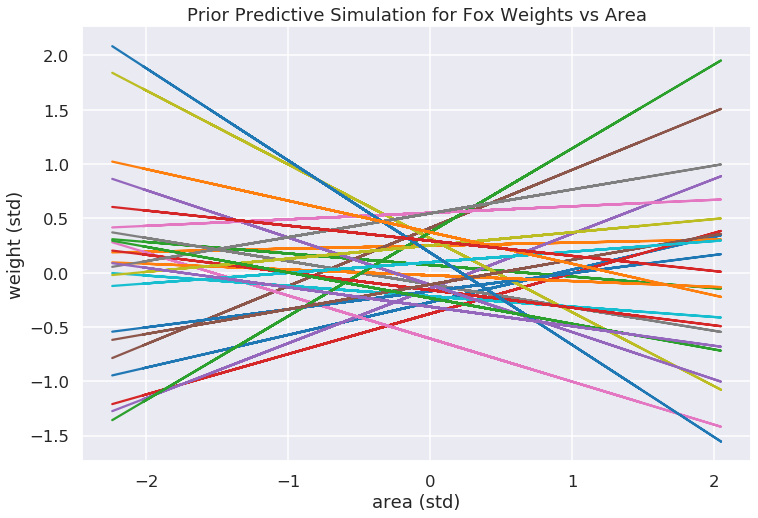

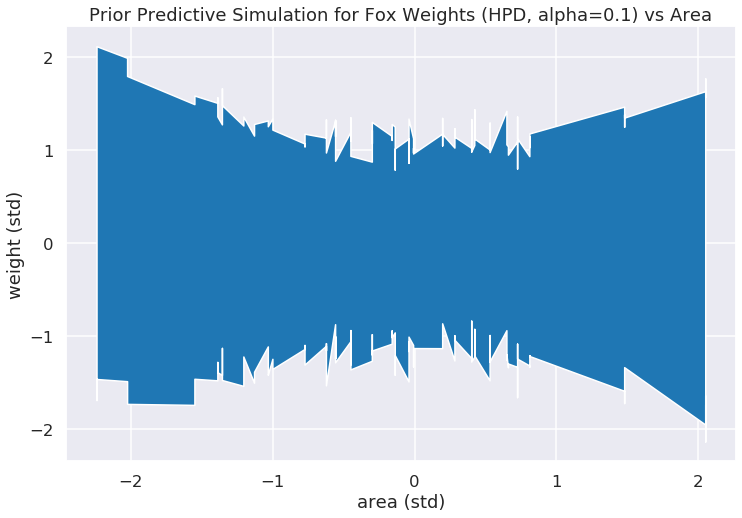

In [6]:
# Now, try again, with more conservative priors
np.random.seed(123)
with pm.Model() as mdl_1:
    a = pm.Normal('a', mu=0, sd=0.25)
    # Name the slope with a little more meaning
    area_effect = pm.Normal('area_effect', mu=0, sd=0.4)
    mu = pm.Deterministic('mu', a + area_effect * fox_std.area.values)
    sigma = pm.Exponential('sigma', lam=2)
    weight = pm.Normal('weight', mu=mu, sd=sigma, observed=fox_std.weight)
    
    prior_1 = pm.sample_prior_predictive()

# Now, plot these lines
plt.figure(figsize=(12,8))
plt.plot(fox_std.area, prior_1['mu'][:N, :].T)
plt.xlabel('area (std)')
plt.ylabel('weight (std)')
plt.title('Prior Predictive Simulation for Fox Weights vs Area')
plt.show()

# Also plot the HPD of the weight for the different areas
plt.figure(figsize=(12,8))
temp = pd.DataFrame(pm.hpd(prior_1['weight'], alpha=0.1),
                    columns=['lower', 'upper'])
temp['area'] = fox_std.area
temp.sort_values('area', inplace=True)
plt.fill_between(temp.area, temp.lower, temp.upper)
plt.xlabel('area (std)')
plt.ylabel('weight (std)')
plt.title(
    'Prior Predictive Simulation for Fox Weights (HPD, alpha=0.1) vs Area')
plt.show()

Much better.  So, let's use these priors for our model, with the full model specification (as given above) now being:
$$\begin{eqnarray}
\alpha &=& \mathrm{Normal}(0, 0.25) \\
\beta &=& \mathrm{Normal}(0, 0.4) \\
\mu &=& \alpha + \beta \cdot area \\
\sigma &=& \mathrm{Exponential}(2) \\
weight &=& \mathrm{Normal}(\mu, \sigma) \\
\end{eqnarray}$$

### Model Infernece

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, area_effect, a]
100%|██████████| 4000/4000 [00:03<00:00, 1056.35it/s]


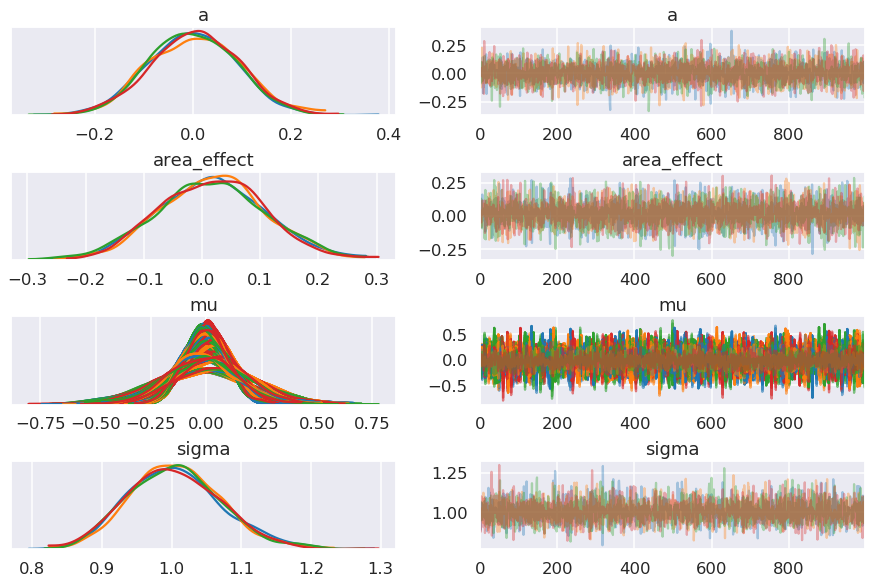

In [7]:
np.random.seed(123)
with mdl_1:    
    # Now, sample from the posterior
    posterior_1 = pm.sample(draws=1000, tune=1000, discard_tuned_samples=True)
    
    # And make posterior predictions
    posterior_pred_1 = pm.sample_posterior_predictive(posterior_1)
    
    azdata_1 = az.from_pymc3(
        trace=posterior_1,
        prior=prior_1,
        posterior_predictive=posterior_pred_1,
        
    )
    
# Plot the trace to confirm things are ok
az.plot_trace(azdata_1, compact=True)
plt.show()

We see from the trace plots that our traces seem to be ok -- we have stationarity, good mixing, and convergence (see pg 287 of the Statistical Rethinking, 2019.02.28 draft).  Let's look at the results, in both summary form, and as a HPD plot.

In [8]:
# Get some summary statistics of the results
summary_1 = az.summary(azdata_1, var_names=['a', 'area_effect', 'sigma'])
summary_1

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.002,0.089,-0.161,0.170,0.001,0.001,5853.0,2090.0,5861.0,3076.0,1.0
area_effect,0.018,0.091,-0.150,0.188,0.001,0.001,6087.0,1981.0,6054.0,3044.0,1.0
sigma,1.006,0.067,0.881,1.128,0.001,0.001,5166.0,5100.0,5219.0,3152.0,1.0


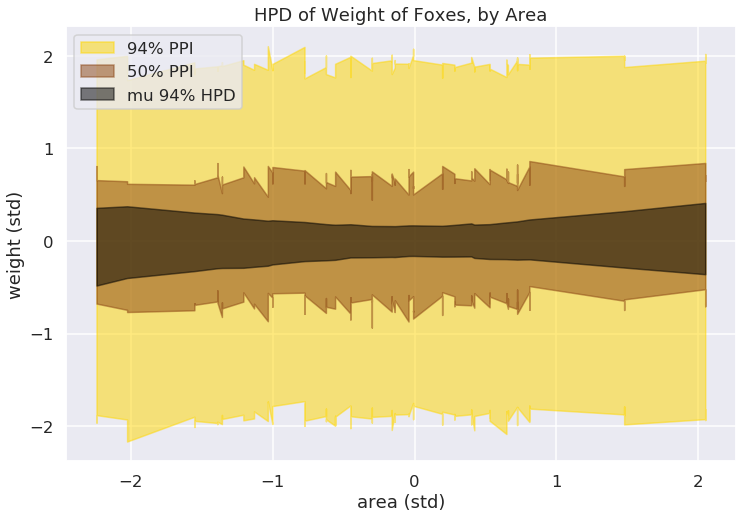

In [9]:
# And plot the HPD
plt.figure(figsize=(12, 8))
# First the default, 94% credible interval of the posterior predictive distribution
az.plot_hpd(fox_std.area, azdata_1.posterior_predictive['weight'],
            smooth=False, color='gold', fill_kwargs={'label': '94% PPI'})
# Now, for a 50% credible interval
az.plot_hpd(fox_std.area, azdata_1.posterior_predictive['weight'], smooth=False,
            credible_interval=0.5, color='saddlebrown',
            fill_kwargs={'label': '50% PPI'})
# Finally, for the predicted "line"
az.plot_hpd(fox_std.area, azdata_1.posterior['mu'], smooth=False, color='black',
            fill_kwargs={'label': 'mu 94% HPD'})

plt.xlabel('area (std)')
plt.ylabel('weight (std)')
plt.title('HPD of Weight of Foxes, by Area')
plt.legend()
plt.show()

From these statistics/ plots, we see that there isn't any correlation between the fox group territory size (`area`) and fox weight.  So, <mark>no, increasing the area available to each fox won't make it healthier</mark>.

---

### Comparison with the solutions
Looking at the solutions, I did essentially the same thing.  Perhaps because my priors were a bit more stringent, the parameter estimates were a bit different, but not in any significant way.

## Problem 2
Now infer the causal impact of adding food to a territory. Would this make foxes heavier? Which covariates do you need to adjust for to estimate the total causal influence of food?

---
If we examine the DAG again:
```
area  ->  avgfood  ->  groupsize
             \              /
              \-> weight <-/
```

we see that `groupsize` is a pipe between `avgfood` and `weight`.  So, if we were to include it in our model, it would close that path (and only give us the direct path between `avgfood` and `weight`.  Since we want the total causal influence of food on weight, let's only include these two variables in our model.  So, for our model, let's use:

$$\begin{eqnarray}
\alpha &=& \mathrm{Normal}(0, 0.25) \\
\beta &=& \mathrm{Normal}(0, 0.4) \\
\mu &=& \alpha + \beta \cdot avgfood \\
\sigma &=& \mathrm{Exponential}(2) \\
weight &=& \mathrm{Normal}(\mu, \sigma) \\
\end{eqnarray}$$

keeping the same priors as before, since `avgfood` is a standardized variable as well.  Now, let's build our model.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, food_effect, a]
100%|██████████| 4000/4000 [00:03<00:00, 1040.47it/s]


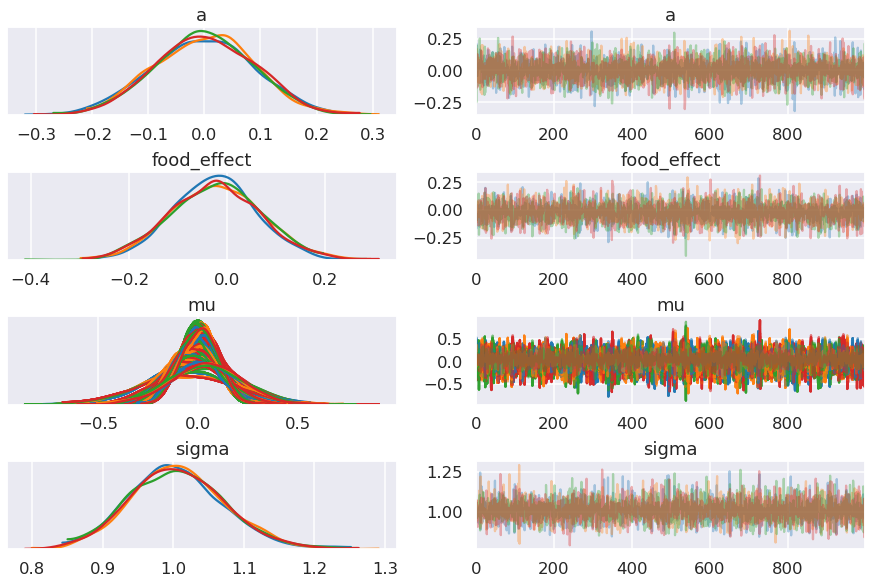

In [10]:
np.random.seed(123)
with pm.Model() as mdl_2:
    a = pm.Normal('a', mu=0, sd=0.25)
    # Name the slope with a little more meaning
    food_effect = pm.Normal('food_effect', mu=0, sd=0.4)
    mu = pm.Deterministic('mu', a + food_effect * fox_std.avgfood.values)
    sigma = pm.Exponential('sigma', lam=2)
    weight = pm.Normal('weight', mu=mu, sd=sigma, observed=fox_std.weight)
    
    # Now, sample from the posterior
    posterior_2 = pm.sample(draws=1000, tune=1000, discard_tuned_samples=True)
    
    # And make posterior predictions
    posterior_pred_2 = pm.sample_posterior_predictive(posterior_2)
    
    azdata_2 = az.from_pymc3(
        trace=posterior_2,
        posterior_predictive=posterior_pred_2,
        
    )
    
# Plot the trace to confirm things are ok
az.plot_trace(azdata_2, compact=True)
plt.show()

The traces again look fine.

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.001,0.088,-0.158,0.167,0.001,0.001,6590.0,2116.0,6577.0,3096.0,1.0
food_effect,-0.023,0.089,-0.188,0.148,0.001,0.001,5950.0,1977.0,5933.0,2643.0,1.0
sigma,1.007,0.067,0.880,1.132,0.001,0.001,5853.0,5726.0,5976.0,3114.0,1.0


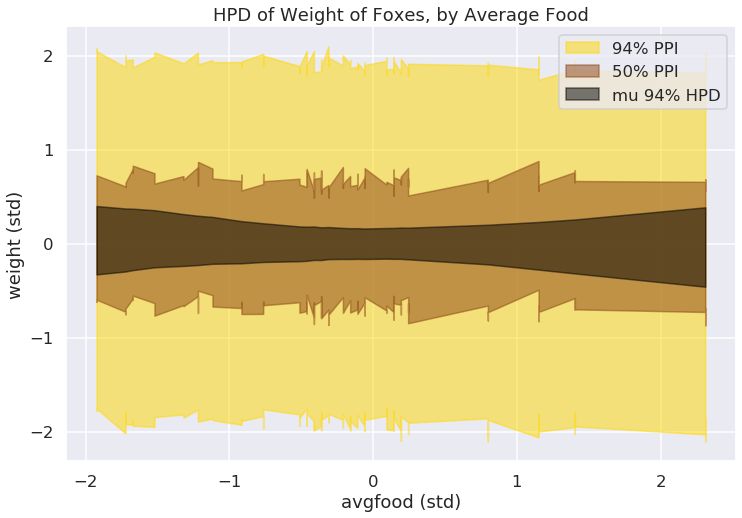

In [11]:
# Get some summary statistics of the results
summary_2 = az.summary(azdata_2, var_names=['a', 'food_effect', 'sigma'])
display(summary_2)

# And plot the HPD
plt.figure(figsize=(12, 8))
# First the default, 94% credible interval of the posterior predictive
# distribution
az.plot_hpd(fox_std.avgfood, azdata_2.posterior_predictive['weight'],
            smooth=False, color='gold', fill_kwargs={'label': '94% PPI'})
# Now, for a 50% credible interval
az.plot_hpd(fox_std.avgfood, azdata_2.posterior_predictive['weight'],
            smooth=False, credible_interval=0.5, color='saddlebrown',
            fill_kwargs={'label': '50% PPI'})
# Finally, for the predicted "line"
az.plot_hpd(fox_std.avgfood, azdata_2.posterior['mu'], smooth=False,
            color='black', fill_kwargs={'label': 'mu 94% HPD'})

plt.xlabel('avgfood (std)')
plt.ylabel('weight (std)')
plt.title('HPD of Weight of Foxes, by Average Food')
plt.legend()
plt.show()

Once again, when we look at the full correlation between average food and the weight of foxes, we see no correlation (so, no, increasing the average food in an area does not increase the weight of a fox).  However, this seems to contradict naive expectations (more food should lead to heavier foxes).  **_We will come back to this at the end of problem 3_**.

---

### Comparison with the solutions
Once again, I did essentially the same thing as the solutions.  One interesting comment of note: the solutions point out that our lack of relationship between average food and weight shouldn't surprise us, if we believe the DAG -- not because of any prior expectations that we have (which is what I pointed out above), but because we already tested for `area` vs `weight`, where we saw no relationship between the two.  If we believe the DAG, since `area` is upstream of `avgfood`, it should have the same overall relationship with `weight` as `avgfood` does.

## Problem 3
Now infer the causal impact of group size. Which covariates do you need to adjust for? Looking at the posterior distribution of the resulting model, what do you think explains these data? That is, can you explain the estimates for all three problems? How do they go together?

---
If we examine the DAG again:
```
area  ->  avgfood  ->  groupsize
             \              /
              \-> weight <-/
```

We see that `avgfood` is a fork leading to both `groupsize` and `weight`.  In order to understand the impact of `groupsize` on `weight`, we will need to close this path by including `avgfood` in our model.  Thus, for our full model specification, let's have:

$$\begin{eqnarray}
\alpha &=& \mathrm{Normal}(0, 0.25) \\
\beta_1 &=& \mathrm{Normal}(0, 0.4) \\
\beta_2 &=& \mathrm{Normal}(0, 0.4) \\
\mu &=& \alpha + \beta_1 \cdot avgfood + \beta_2 \cdot groupsize \\
\sigma &=& \mathrm{Exponential}(2) \\
weight &=& \mathrm{Normal}(\mu, \sigma) \\
\end{eqnarray}$$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, groupsize_effect, food_effect, a]
100%|██████████| 4000/4000 [00:04<00:00, 824.85it/s]


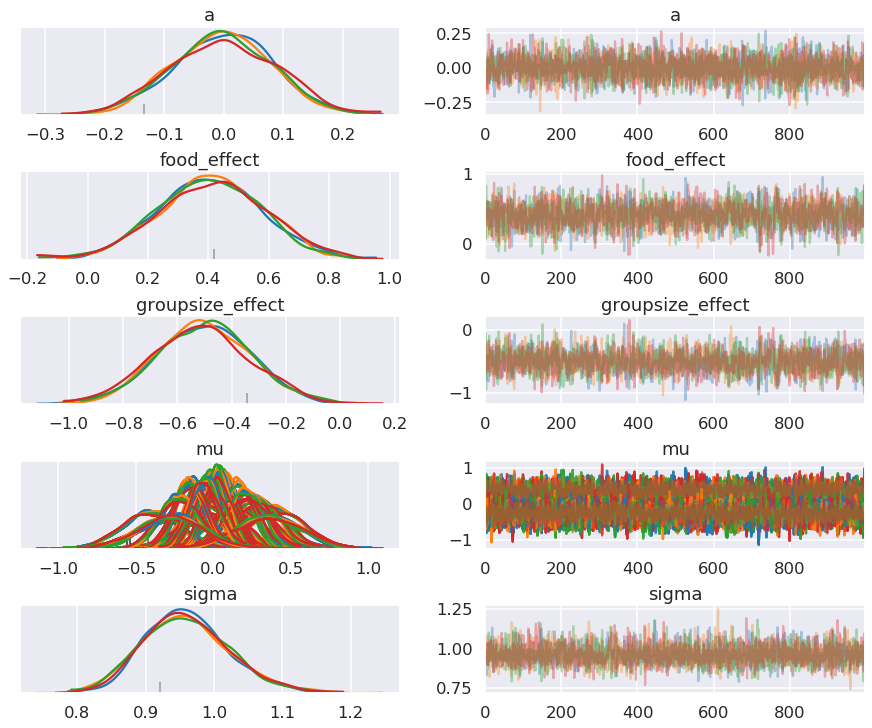

In [12]:
np.random.seed(123)
with pm.Model() as mdl_3:
    a = pm.Normal('a', mu=0, sd=0.25)
    # Name these with a little more meaning
    food_effect = pm.Normal('food_effect', mu=0, sd=0.4)
    groupsize_effect = pm.Normal('groupsize_effect', mu=0, sd=0.4)
    mu = pm.Deterministic('mu', a + 
                          (food_effect * fox_std.avgfood.values) +
                          (groupsize_effect * fox_std.groupsize))
    sigma = pm.Exponential('sigma', lam=2)
    weight = pm.Normal('weight', mu=mu, sd=sigma, observed=fox_std.weight)
    
    # Now, sample from the posterior
    posterior_3 = pm.sample(draws=1000, tune=1000, discard_tuned_samples=True)
    
    # And make posterior predictions
    posterior_pred_3 = pm.sample_posterior_predictive(posterior_2)
    
    azdata_3 = az.from_pymc3(
        trace=posterior_3,
        posterior_predictive=posterior_pred_3,
        
    )
    
# Plot the trace to confirm things are ok
az.plot_trace(azdata_3, compact=True)
plt.show()

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.002,0.084,-0.163,0.149,0.001,0.001,4003.0,1740.0,3995.0,2943.0,1.0
food_effect,0.408,0.173,0.085,0.728,0.004,0.003,1955.0,1955.0,1967.0,2177.0,1.0
groupsize_effect,-0.502,0.173,-0.813,-0.165,0.004,0.003,2062.0,2062.0,2063.0,2205.0,1.0
sigma,0.960,0.063,0.843,1.081,0.001,0.001,3930.0,3894.0,3953.0,2848.0,1.0


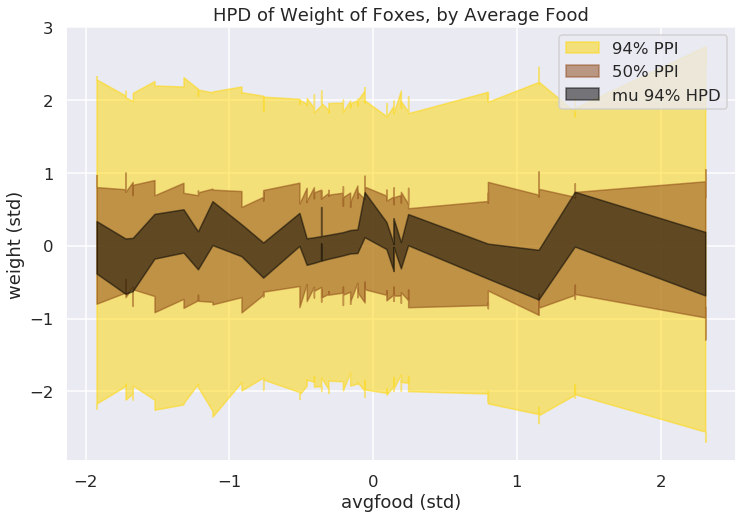

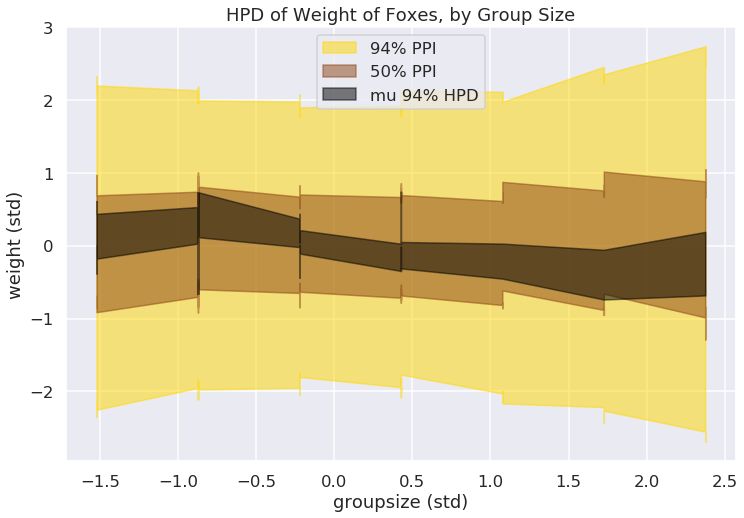

In [13]:
# Get some summary statistics of the results
summary_3 = az.summary(azdata_3, var_names=['a', 'food_effect',
                                            'groupsize_effect', 'sigma'])
display(summary_3)

# And plot the HPD of weight vs average food
plt.figure(figsize=(12, 8))
# First the default, 94% credible interval of the posterior predictive distribution
az.plot_hpd(fox_std.avgfood, azdata_3.posterior_predictive['weight'],
            smooth=False, color='gold', fill_kwargs={'label': '94% PPI'})
# Now, for a 50% credible interval
az.plot_hpd(fox_std.avgfood, azdata_3.posterior_predictive['weight'],
            smooth=False, credible_interval=0.5, color='saddlebrown',
            fill_kwargs={'label': '50% PPI'})
# Finally, for the predicted "line"
az.plot_hpd(fox_std.avgfood, azdata_3.posterior['mu'], smooth=False,
            color='black', fill_kwargs={'label': 'mu 94% HPD'})

plt.xlabel('avgfood (std)')
plt.ylabel('weight (std)')
plt.title('HPD of Weight of Foxes, by Average Food')
plt.legend()
plt.show()

# And plot the HPD of weight vs group size
plt.figure(figsize=(12, 8))
# First the default, 94% credible interval of the posterior predictive distribution
az.plot_hpd(fox_std.groupsize, azdata_3.posterior_predictive['weight'],
            smooth=False, color='gold', fill_kwargs={'label': '94% PPI'})
# Now, for a 50% credible interval
az.plot_hpd(fox_std.groupsize, azdata_3.posterior_predictive['weight'],
            smooth=False, credible_interval=0.5, color='saddlebrown',
            fill_kwargs={'label': '50% PPI'})
# Finally, for the predicted "line"
az.plot_hpd(fox_std.groupsize, azdata_3.posterior['mu'], smooth=False,
            color='black', fill_kwargs={'label': 'mu 94% HPD'})

plt.xlabel('groupsize (std)')
plt.ylabel('weight (std)')
plt.title('HPD of Weight of Foxes, by Group Size')
plt.legend()
plt.show()

Perhaps as expected, the HPD plots don't give a very good picture (since it's collapsing a 3-D plane down into a 2-D surface), but with the summary statistics, we can see that both the average food and group size effects are significantly non-zero, with increasing food being positively correlated with fox weight, while group size being negatively correlated with weight (both of these are what we would naively expect).  To summarize our efforts from all three models, let's create a forest plot with all parameters on the same plot.

/home/koman/miniconda3/envs/srt/lib/python3.7/site-packages/arviz/plots/forestplot.py:207: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/home/koman/miniconda3/envs/srt/lib/python3.7/site-packages/arviz/plots/forestplot.py:208: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


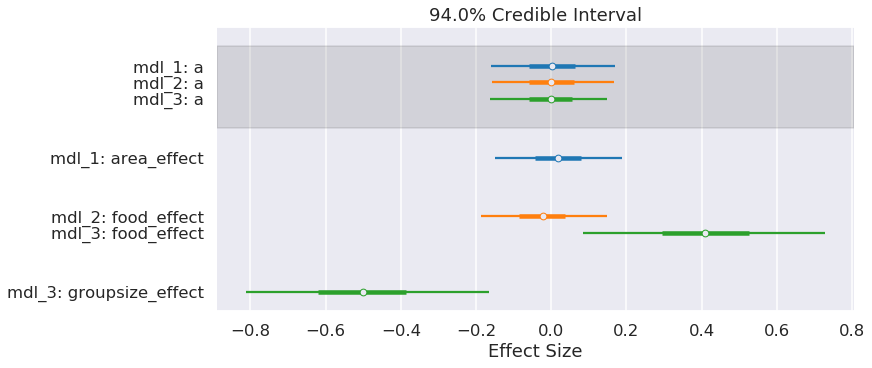

In [14]:
# Plot all parameters on the same plot, facilitating comparisons between
# the different models.
az.plot_forest(
    [azdata_1, azdata_2, azdata_3], kind='forestplot',
    model_names=['mdl_1', 'mdl_2', 'mdl_3'],
    var_names=['a', 'area_effect', 'food_effect', 'groupsize_effect'],
    combined=True,
    figsize=(12, 5))
ax = plt.gca()
ax.xaxis.grid(True, which='both')
plt.xlabel('Effect Size')
plt.show()

Looking at the above, we see (something we hadn't pointed out earlier), all three intercept terms are overlapping with zero.  This is as we would expect, since all variables were standardized, so we would expect foxes in average sized areas with average amounts of food, living in average sized groups, to have average weight.

We also observe in Model 2 once again (where this model was looking at the total causal impact of food on weight) no correlation between average food and weight.  However, in Model 3 (where we included both group size and average food in our model), we now have a positive correlation between food and weight.

So, what is going on here?  If we examine our DAG once again:
```
area  ->  avgfood  ->  groupsize
             \              /
              \-> weight <-/
```
we see that `weight` is hypothesized to be directly caused by both `avgfood` and `groupsize`.  So, as we add food to an area, it will, indeed, increase the average weight of a fox in the area, but there comes a point when there will be enough food to sustain yet another fox, bringing back down the amount of food per fox that is available, keeping the weight of a fox from straying too far from its mean value.  So, if we ignore `groupsize`, we end up not seeing any correlation between `avgfood` and `weight`.

Let's look at the data directly with these three variables to solidify this point.

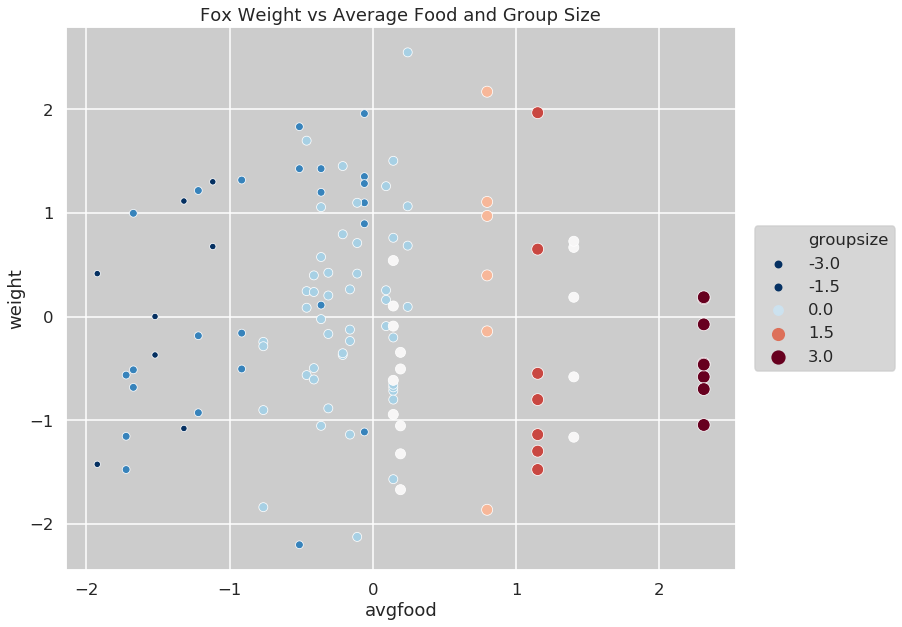

In [15]:
# Plot avgfood vs weight, where we also indicate the groupsize
plt.figure(figsize=(12,10))
# Make the grid background a bit darker so we can see the "white" points.
with sns.axes_style(rc={'axes.facecolor': '.8'}):
    sns.scatterplot('avgfood', 'weight', hue='groupsize', size='groupsize', palette='RdBu_r', data=fox_std)
    plt.legend(bbox_to_anchor=(1.25, 0.5), loc=5)
    plt.title('Fox Weight vs Average Food and Group Size')
    plt.show()

Above, we have `avgfood` vs `weight`, where I've added `groupsize` as both the color and size of the points (`groupsize` increases from blue to red (passing through white), and goes from smaller to larger points).

As we saw in our inference, as a whole (ignoring color/size), we don't really see any pattern between `avgfood` and `weight`.  However, if we look within a band of points with similar levels of food, we observe smaller grouped foxes (smaller points/ more blue) to be heavier than foxes from larger groups (more red/ larger points) (If you have a hard time seeing this, look, for example between `avgfood` = \[-0.5, 0.5\] where dark blue foxes are heavier than light blue foxes which are heavier than white foxes, on average.

As for how `area` plays in to `weight`, it's more or less the same as for `avgfood` -- we don't see any correlation with `weight` directly, but if we had included `groupsize` in Model 1, we likely would have seen a positive relationship between `area` and `weight`, with the same negative relationship between `groupsize`, and `weight`.  This (and visual inspection) will be left as work further work that can be done for interested parties.

---

### Comparison with the solutions
Once again, I did essentially the same thing as the solutions.  The biggest difference is in the explanation of the differences between the different models, where the solutions are more succinct and tie in to evolutionary theory (and I also discussed a bit of the how `area` vs `weight` play a part, since the question prompt was vague enough that I though that was a required part of what was being asked).